In [38]:
import pickle
import warnings
import random
import torch

import numpy as np
import pandas as pd

from tqdm import tqdm
from glob import glob
from collections import OrderedDict
from scipy.spatial import distance

from torch.nn import functional as F

In [2]:
import pickle
import warnings
import random

import numpy as np
import pandas as pd

from tqdm import tqdm
from glob import glob
from collections import OrderedDict
from scipy.spatial import distance

from torch.nn import functional

In [3]:
warnings.simplefilter('ignore')
alt.data_transformers.enable('default', max_rows=None)
pd.options.display.max_rows = 200

In [4]:
embeds, rows = [], []

for path in tqdm(glob('../data/b13-embeds/*.p')):
    with open(path, 'rb') as fh:
        
        lines = pickle.load(fh)

        for line in lines:
            title = ' '.join(line.pop('tokens'))
            embeds.append(line.pop('embedding'))
            rows.append(OrderedDict(title=title, **line))

100%|██████████| 99/99 [00:37<00:00,  3.21it/s]


In [5]:
embeds = np.stack(embeds)

In [6]:
df = pd.DataFrame(rows)

In [7]:
df.label.unique()

array(['dailycaller.com', 'thehill.com', 'bloomberg.com', 'breitbart.com',
       'buzzfeed.com', 'cnn.com', 'nytimes.com', 'apnews.com',
       'huffingtonpost.com', 'washingtonpost.com', 'wsj.com',
       'foxnews.com', 'dailykos.com'], dtype=object)

In [8]:
embeds.shape

(982833, 512)

In [ ]:
torch.fr

In [53]:
def sampled_pw_ds(d, n=100000):
    
    d_embeds = embeds[df[df.label==d].index]
    
    idx1 = np.random.choice(range(len(d_embeds)), n)
    idx2 = np.random.choice(range(len(d_embeds)), n)
    
    x1 = torch.from_numpy(d_embeds[idx1])
    x2 = torch.from_numpy(d_embeds[idx2])
    
    ds = F.cosine_similarity(x1, x2)
    
    return ds.numpy()

In [10]:
domains = df.label.unique()

In [58]:
xs = [
    sampled_pw_ds(d, 500000)
    for d in tqdm(domains)
]

100%|██████████| 13/13 [00:34<00:00,  2.67s/it]


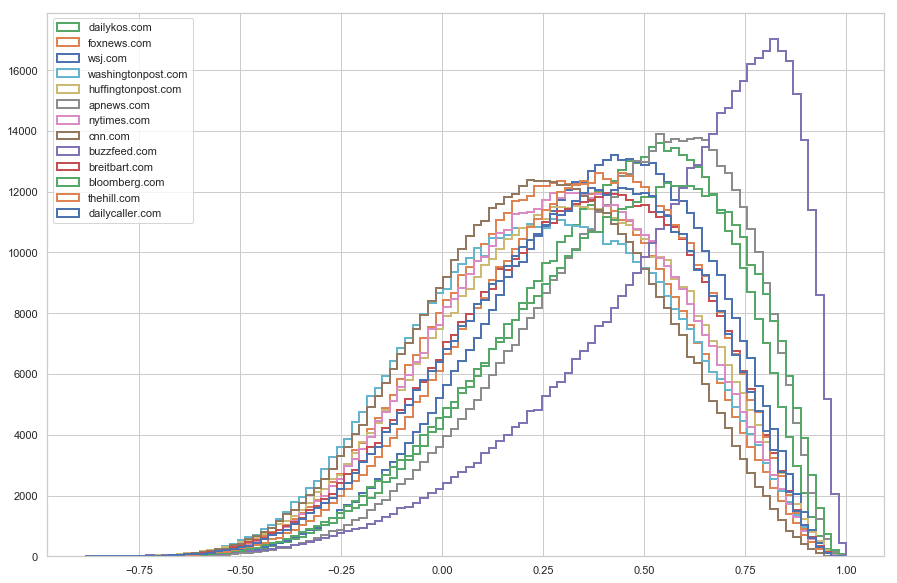

In [60]:
plt.figure(figsize=(15,10))
ys, x, _ = plt.hist(xs, histtype='step', bins=100, linewidth=2, label=domains)
plt.legend(loc='upper left')

In [24]:
def diameter(d, metric):
    return np.median(sampled_pw_ds(d, metric))

In [25]:
rows = [
    (d, diameter(d, distance.cosine))
    for d in tqdm(df.label.unique())
]
    
diameter_df = pd.DataFrame(rows, columns=('domain', 'd'))

100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


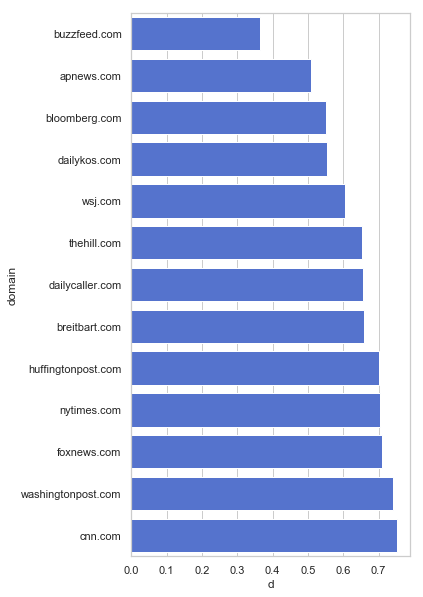

In [26]:
diameter_df.sort_values('d', inplace=True)
plt.figure(figsize=(5,10))
sns.barplot(x='d', y='domain', data=diameter_df, color='RoyalBlue')

In [30]:
def focality(d, metric):
    return np.var(sampled_pw_ds(d, metric))

In [31]:
rows = [
    (d, focality(d, distance.cosine))
    for d in tqdm(df.label.unique())
]
    
focality_df = pd.DataFrame(rows, columns=('domain', 'd'))

100%|██████████| 13/13 [00:12<00:00,  1.06it/s]


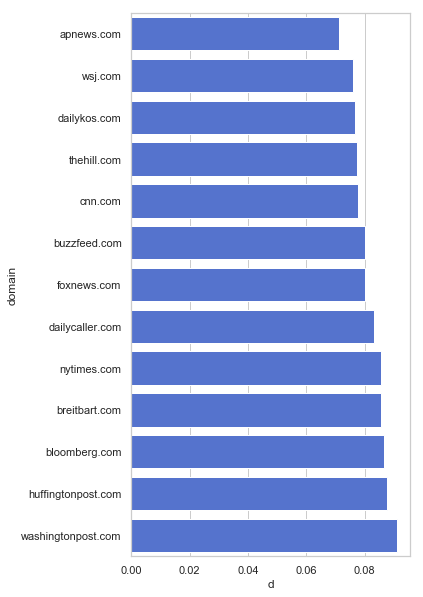

In [32]:
focality_df.sort_values('d', inplace=True)
plt.figure(figsize=(5,10))
sns.barplot(x='d', y='domain', data=focality_df, color='RoyalBlue')